# Predicting Animal Shelter Outcomes
#### Comparing Gradient Boosting, AdaBoost, and Random Forest

### This Notebook Contains:
* Introduction
* Step 1 - Downloading Data
* Step 2 - Data Visualization
* Step 3 - Data Cleaning
* Step 4 - Feature Generation
* Step 5 - Test/Train
* Step 6 - Model Selection
    * Random Forest
    * AdaBoost
    * Gradient Boosting

### About

I've been a volunteer at the [Austin Animal Center](http://www.austintexas.gov/department/aac), one of the largest No Kill shelters in the US (they house over 18,000 animals every year) and was thrilled to see they provided some of their data to be used in a [Kaggle](https://www.kaggle.com/c/shelter-animal-outcomes) competition!

AAC is interested in predicting the outcome of animals that pass through their shelter... Will they get adopted? Will they be returned to their owner? 

This dataset includes information about cats and dogs (breed, sex, color, age, etc.) from October 2013 - March 2016. Each animal has a unique ID and an associated "outcome": Adoption, Died, Euthanasia, Return to owner, and Transfer. 

### Step 1- Data Download

Import important packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
import sklearn
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Download and inspect the data

In [2]:
path='~/train.csv'
download=pd.DataFrame(pd.read_csv(path))
print(download.describe())
download.info()

       AnimalID   Name             DateTime OutcomeType OutcomeSubtype  \
count     26729  19038                26729       26729          13117   
unique    26729   6374                22918           5             16   
top     A701616    Max  2015-08-11 00:00:00    Adoption        Partner   
freq          1    136                   19       10769           7816   

       AnimalType SexuponOutcome AgeuponOutcome                   Breed  \
count       26729          26728          26711                   26729   
unique          2              5             44                    1380   
top           Dog  Neutered Male         1 year  Domestic Shorthair Mix   
freq        15595           9779           3969                    8810   

              Color  
count         26729  
unique          366  
top     Black/White  
freq           2824  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null o

In [3]:
download.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


The data looks like it's mostly descriptive. Our variable of interest is __OutcomeType__ but there is also an __OutcomeSubtype__. I won't use __OutcomeSubtype__ in my model, because it seems like we would only know the outcome subtype once we knew the outcome type. 

The breed and age of the animal will likely be very important, as I suspect "cuter" breeds and younger animals will be more likely to get adopted. Older animals may be more likely to die or be put down.

### Step 2 - Data Exploration

In [4]:
data=download.copy() #Copy our downloaded dataset to play around with it 

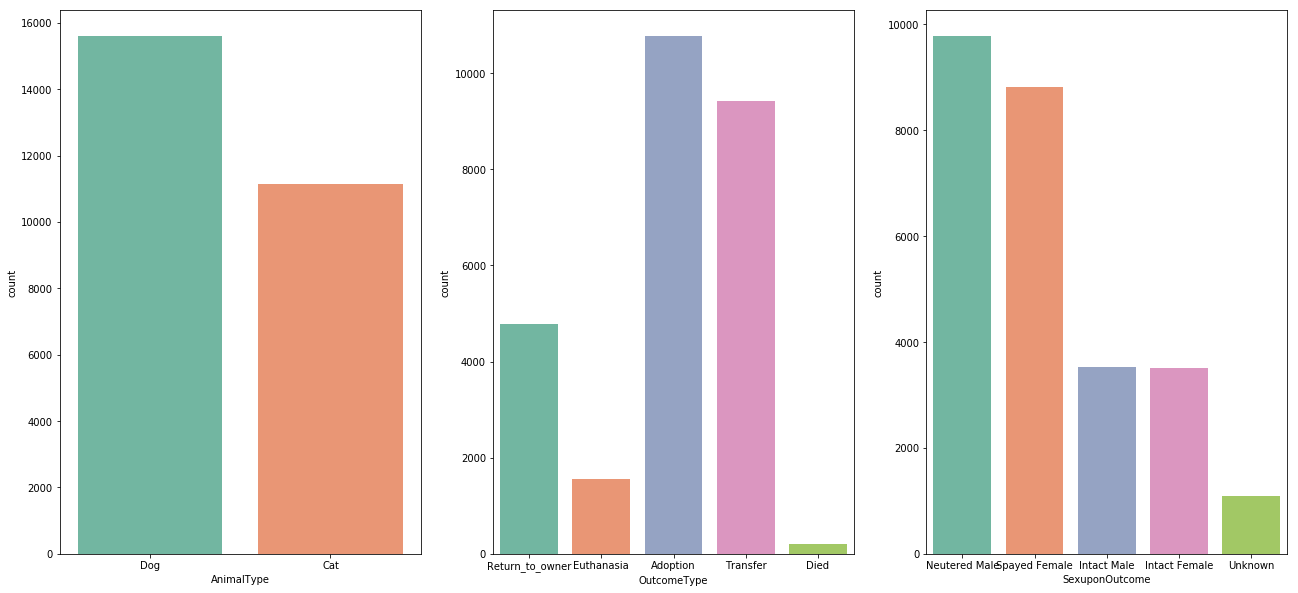

In [5]:
fig,ax= plt.subplots(1,3, figsize=(22, 10))
sns.countplot(data.AnimalType, palette='Set2', ax=ax[0])
sns.countplot(data.OutcomeType, palette='Set2', ax=ax[1])
sns.countplot(data.SexuponOutcome, palette='Set2', ax=ax[2])
fig.show()

Most animals get adopted or transfered! And it looks like the majority are either spayed or neutered. From what I know about most animal shelters, if an animal isn't neutered they can't be adopted until they are, so this may be an important feature as well. 

In [7]:
print('Outcome Sub Types:' ,data.OutcomeSubtype.unique())
print('Outcome Types:',data.OutcomeType.unique())

Outcome Sub Types: [nan 'Suffering' 'Foster' 'Partner' 'Offsite' 'SCRP' 'Aggressive'
 'Behavior' 'Rabies Risk' 'Medical' 'In Kennel' 'In Foster' 'Barn'
 'Court/Investigation' 'Enroute' 'At Vet' 'In Surgery']
Outcome Types: ['Return_to_owner' 'Euthanasia' 'Adoption' 'Transfer' 'Died']


### Step 3 - Feature Generation

Let's separate the sex of the animal from whether or not they are neutered. Here I will consider spayed to be neutered. 

In [8]:
data["Sex"]=pd.np.where(data.SexuponOutcome.str.contains("Male"), "Male",
                    pd.np.where(data.SexuponOutcome.str.contains("Female"), "Female", "Unknown"))

data['Neutered']=pd.np.where(data.SexuponOutcome.str.contains("Neutered"), "Neutered",
                    pd.np.where(data.SexuponOutcome.str.contains("Spayed"), "Neutered", 
                    pd.np.where(data.SexuponOutcome.str.contains("Intact"), "Intact", "Unknown")))

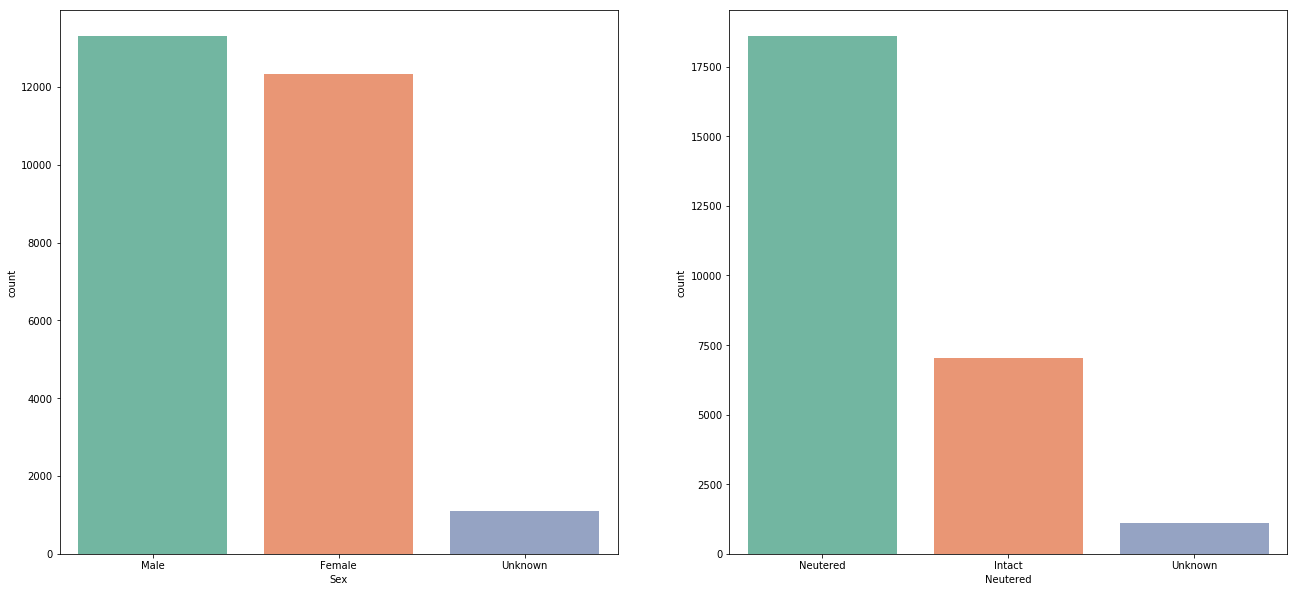

In [9]:
fig,ax= plt.subplots(1,2, figsize=(22, 10))
sns.countplot(data.Sex, palette='Set2', ax=ax[0])
sns.countplot(data.Neutered, palette='Set2', ax=ax[1])
fig.show()

Now let's take a look at breeds. I suspect there are tons of different breeds and many combinations of breeds we could use. We can try to simplify this later, but for now let's separate out the breed into __Mix__ and __Purebred__.

In [10]:
data.Breed.unique().shape

(1380,)

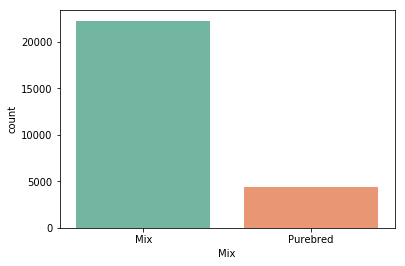

In [11]:
#Separate mix and not mix
data["Mix"]=pd.np.where(data.Breed.str.contains("Mix"), "Mix", "Purebred")
sns.countplot(data.Mix, palette='Set2')               

Looking back at the data, this field may not be very useful considering I see some entries that don't have the word "Mix" in them but are formatted as "Breed1/ Breed2". Clearly these are also mixes. Let's come back to this later.

Now let's take a peek at whether the animal having a __Name__ is important. If it proves to be important, Animal Shelters should try their best to assign a random name to the animals they receive to make them seem more adoptable! (Assuming the relationship between adoption and name is causal.... it could also be that stray dogs are less likely to be adopted).

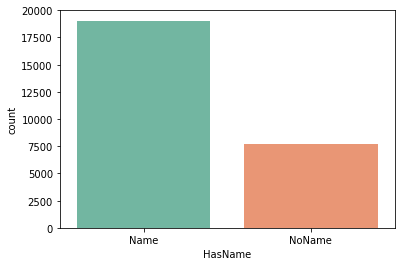

In [12]:
#Separate out animals who have a name from those that don't
data["HasName"]=pd.np.where(data.Name.isnull(), "NoName", "Name")
sns.countplot(data.HasName, palette='Set2')

### Step 3 - Tidying

The __AgeuponOutcome__ will most likely be a very important factor. Let's change this field to a useful numeric.

In [13]:
data['Age Value'], data['Age Measure']= data['AgeuponOutcome'].str.split(' ', 1).str

In [14]:
data["Age"]=np.where(data["Age Measure"]=="weeks", 
                     data["Age Value"].astype(float)/52, 
                     np.where(data["Age Measure"]=="months", 
                            data["Age Value"].astype(float)/12, 
                            data["Age Value"].astype(float)))        

In [15]:
data["Age"].fillna(data["Age"].mean(), inplace=True) #Impute in NAs with the mean

(array([  1.00650000e+04,   5.46200000e+03,   3.85900000e+03,
          1.93200000e+03,   1.12100000e+03,   1.01600000e+03,
          7.20000000e+02,   5.31000000e+02,   5.36000000e+02,
          2.88000000e+02,   4.46000000e+02,   1.26000000e+02,
          2.34000000e+02,   1.43000000e+02,   9.70000000e+01,
          8.50000000e+01,   3.60000000e+01,   1.70000000e+01,
          1.00000000e+01,   5.00000000e+00]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.]),
 <a list of 20 Patch objects>)

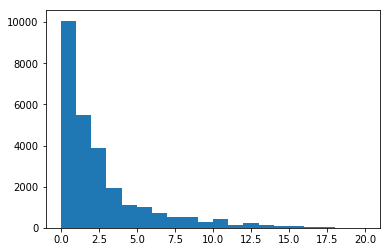

In [16]:
plt.hist(data.Age.astype(int), bins=20)

We have lots of relatively young animals! 

Let's move on to tidying __DateTime__. We can separate out the Day, Month, and Hour as well as derive the general time of day of the outcome.

In [17]:
Split= pd.DataFrame(data.DateTime.str.split(' ',1).tolist(),columns = ['day','time'])
Split['Hour'] = Split['time'].astype(str).str[0:2]
Split['Month']=Split['day'].astype(str).str[5:7]
Split['Day']=Split['day'].astype(str).str[8:10]

v=[]
for row in range(len(Split.Hour)):
    if int(Split.Hour[row])<6:
        v.append("Night")
    elif int(Split["Hour"][row])>=6 and int(Split["Hour"][row])<11:
        v.append("Morning")
    elif int(Split["Hour"][row])>=11 and int(Split["Hour"][row])<17:
        v.append("Afternoon")
    elif int(Split["Hour"][row])>=17 and int(Split["Hour"][row])<19:
        v.append("Evening")
    else: 
        v.append("Night")


data["DateBucket"]=v
data["Hour"]=Split["Hour"]
data["Month"]=Split["Month"]
data["Day"]=Split["Day"]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11308cfd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1148accf8>]], dtype=object)

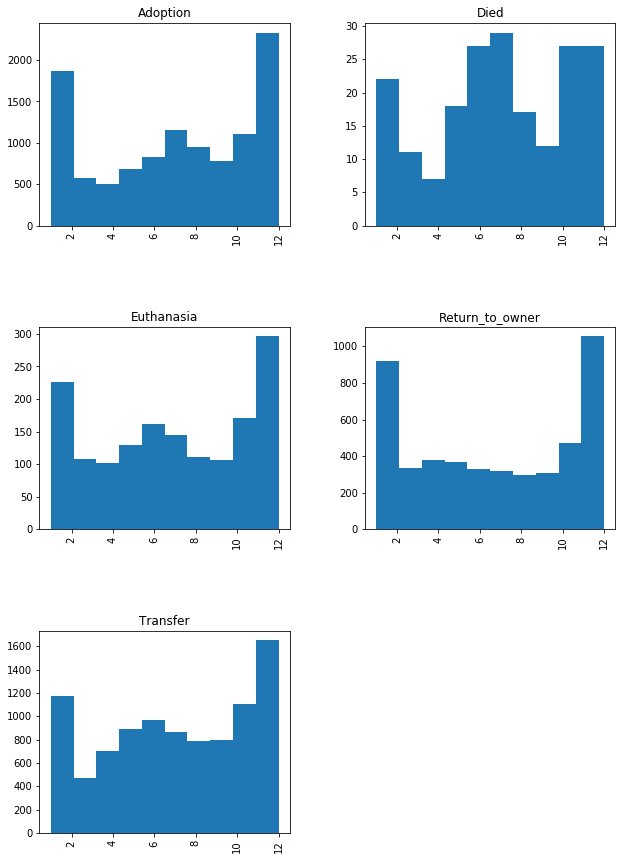

In [18]:
Split['Month'].astype(int).hist(by=data['OutcomeType'], figsize=(10,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114bfdf60>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x114c2bf98>]], dtype=object)

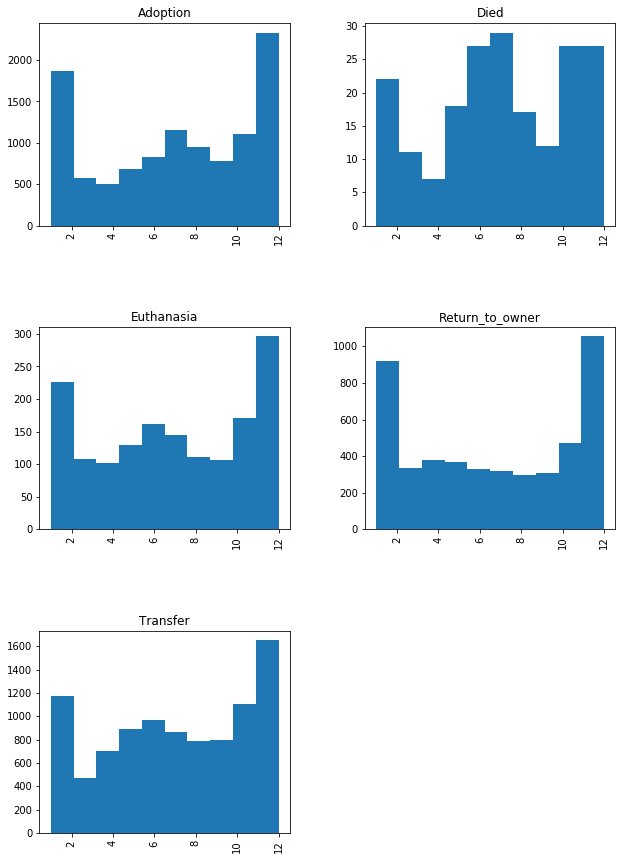

In [19]:
Split['Month'].astype(int).hist(by=data['OutcomeType'], figsize=(10,15))

Wow! We can see that a lot of activity happens around December/January! A lot of deaths surprisingly happen in the middle of summer though. Could this be that baby animals born in the spring don't make it past a few months of age?

In [20]:
Split["Hour"]=Split["Hour"].astype(int)
type(Split["Hour"][0])
Split.Hour[2]<5

False

(array([  3.78000000e+02,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          1.00000000e+01,   1.10000000e+02,   3.02000000e+02,
          1.27800000e+03,   4.05000000e+02,   2.04200000e+03,
          2.51300000e+03,   2.46800000e+03,   2.80000000e+03,
          2.68200000e+03,   2.69000000e+03,   4.16200000e+03,
          3.68400000e+03,   1.08300000e+03,   7.70000000e+01,
          1.80000000e+01,   5.00000000e+00,   2.00000000e+01]),
 array([  0.        ,   0.95833333,   1.91666667,   2.875     ,
          3.83333333,   4.79166667,   5.75      ,   6.70833333,
          7.66666667,   8.625     ,   9.58333333,  10.54166667,
         11.5       ,  12.45833333,  13.41666667,  14.375     ,
         15.33333333,  16.29166667,  17.25      ,  18.20833333,
         19.16666667,  20.125     ,  21.08333333,  22.04166667,  23.        ]),
 <a list of 24 Patch objects>)

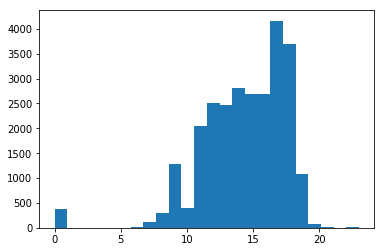

In [21]:
plt.hist(Split.Hour.astype(int), bins=24)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114ff0a20>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11548fc18>]], dtype=object)

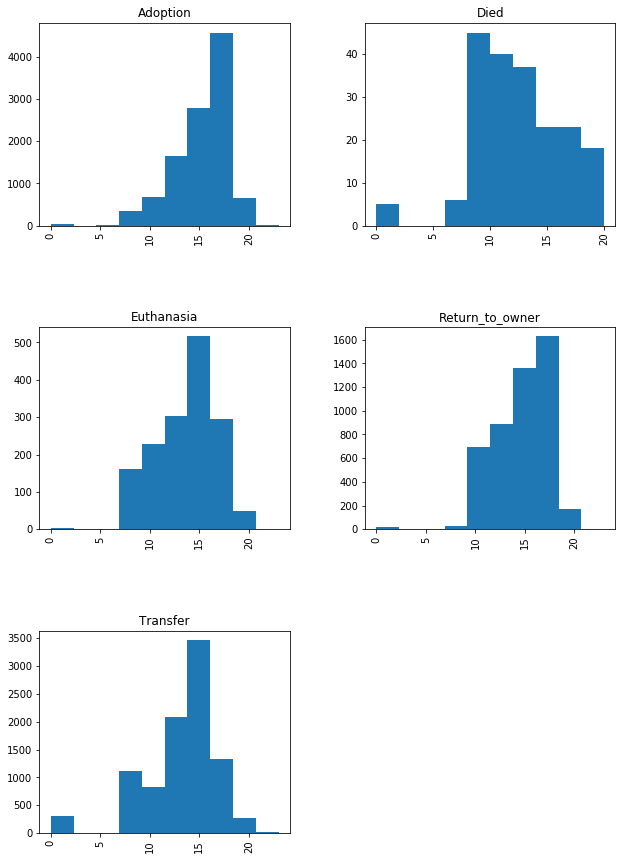

In [22]:
Split['Hour'].astype(int).hist(by=data['OutcomeType'], figsize=(10,15))

We can see that deaths spike in the morning while all other outcomes peak in the afternoon.

In [23]:
Split.head()

,day,time,Hour,Month,Day
0,2014-02-12,18:22:00,18,02,12
1,2013-10-13,12:44:00,12,10,13
2,2015-01-31,12:28:00,12,01,31
3,2014-07-11,19:09:00,19,07,11
4,2013-11-15,12:52:00,12,11,15


Now let's try to clean up the color of the animal along with its breed. Both of these measures have way too many different combinations, so let's split them into three or four separate word buckets. 

In [24]:
cls=pd.DataFrame(data.Color.values, columns=["Color"])

cls["Color"]=cls["Color"].str.replace('/', ' ') 
c = cls.Color.str.split(expand=True).stack()

c=c.groupby(level=0).apply(lambda x: ' '.join(x.sort_values().drop_duplicates()))

In [25]:
firstcols = pd.DataFrame(c.str.split(' ',3).tolist(),columns = ['c1','c2', 'c3', 'c4'])

data["Color1"]=firstcols["c1"]
data["Color2"]=firstcols["c2"]
data["Color3"]=firstcols["c3"]
data["Color4"]=firstcols["c4"]

In [26]:
bds=pd.DataFrame(data.Breed.values, columns=["Breed"])# index=data.AnimalID)

bds["Breed"]=bds["Breed"].str.replace('/', ' ') 
bds["Breed"]=bds["Breed"].str.replace('Mix', '')
s = bds.Breed.str.split(expand=True).stack()

s=s.groupby(level=0).apply(lambda x: ' '.join(x.sort_values().drop_duplicates()))

In [27]:
firstcols = pd.DataFrame(s.str.split(' ',3).tolist(),columns = ['b1','b2', 'b3', 'b4'])

data["Breed1"]=firstcols["b1"]
data["Breed2"]=firstcols["b2"]
data["Breed3"]=firstcols["b3"]
data["Breed4"]=firstcols["b4"]

We've done a lot of work, now let's use only the columns we think will be useful. We are going to need to one-hot encode these values so sklearn can read them in properly. I will used Pandas' __get_dummies__ to one-hot encode instead of the package in sklearn, because my columns are all strings.

In [28]:
cols=["AnimalType", "Sex", "Neutered", "HasName", "Mix", "Color1","Color2", "Color3", "Color4", "Breed1", "Breed2", "Breed3", "Breed4", "Hour", "Month", "Day", "DateBucket"]

def Binarize(columns, dataset):
    x=dataset[columns].copy()
    for names in cols:
        x=pd.concat([x, pd.get_dummies(dataset[names])], axis=1)
    x=x.drop(cols,1)
    return x

xy=Binarize(cols,data)

Finally let's add Age back into our now one-hot encoded frame

In [29]:
xy["Age"]=data["Age"]

Finally, let's binarize our __OutcomeTypes__.

In [30]:
y=data["OutcomeType"]
y_enc, y_cats=y.factorize()
y=y_enc.reshape(-1,1)

In [31]:
#Let's add y to our dataframe so we can split it into train and test later
xy["Y"]=y_enc

### Step 5 - Split train vs test data

In [32]:
from sklearn.model_selection import train_test_split

train_set, test_set= train_test_split(xy, test_size=0.2, random_state=42)

x_train=train_set.drop("Y", axis=1)
y_train=train_set["Y"].copy().reshape(-1,1)
x_test=test_set.drop("Y", axis=1)
y_test=test_set["Y"].copy().reshape(-1,1)

### Step 6 - Model Selection
#### Random Forest Classifier
Random forests are great ensemble learning methods that can do well in our classification goal. It will compile multiple decision trees trained on different sub-samples of our data and average their responses.

Let's perform a gridsearch to find optimal hyperparameters for our forest. We will tune maximum number features to use in determining the best tree splits, and the maximum depth of the trees. 

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid=[
    {'max_features':[500, 400], 'max_depth':[7,9,10]}
]

forest_clf2=RandomForestClassifier(oob_score=True, random_state=42)
grid_search=GridSearchCV(forest_clf2, param_grid, #cv=3,
                        scoring='log_loss')
grid_search.fit(x_train, y_train.ravel())

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_features': [500, 400], 'max_depth': [7, 9, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='log_loss', verbose=0)

In [40]:
grid_search.best_params_

{'max_depth': 10, 'max_features': 400}

In [41]:
forest_clf=RandomForestClassifier(n_estimators=100, max_features=400, max_depth=10, oob_score=True, n_jobs=-1,random_state=42)
forest_clf.fit(x_train,y_train)
forest_clf_pred=forest_clf.predict(x_train)

from sklearn import metrics
score=metrics.accuracy_score(y_train, forest_clf_pred)
print("Train Accuracy= ", score)

Train Accuracy=  0.702473927887


In [42]:
test_forest_clf_pred=forest_clf.predict(x_test)
score=metrics.accuracy_score(y_test, test_forest_clf_pred)
print("Test Accuracy= ",score)

Test Accuracy=  0.665357276468


In [49]:
print(forest_clf.predict_proba(x_test))
print(forest_clf.feature_importances_)


[[  4.76662082e-01   5.37546662e-02   2.96414991e-01   1.70246181e-01
    2.92208011e-03]
 [  1.26491273e-02   8.85438159e-04   9.54003146e-01   3.16522347e-02
    8.10054334e-04]
 [  6.28243590e-03   7.59550496e-02   0.00000000e+00   9.07537203e-01
    1.02253111e-02]
 ..., 
 [  9.66392014e-03   1.87127183e-03   8.61918391e-01   1.26316546e-01
    2.29871496e-04]
 [  3.34714952e-03   5.66714303e-02   2.04830878e-03   9.19507149e-01
    1.84259623e-02]
 [  4.61528009e-01   3.00172958e-02   3.98495478e-01   1.05278216e-01
    4.68100087e-03]]
[  2.53339517e-02   2.06459818e-02   3.66186943e-03   3.03168675e-03
   4.23118338e-02   2.53453068e-01   4.29069374e-02   4.89918213e-02
   6.88447919e-02   1.75541987e-03   0.00000000e+00   8.09916380e-05
   2.62235183e-03   2.76631056e-03   6.09972416e-04   2.10296358e-03
   4.33458812e-04   3.62532772e-04   6.03973409e-04   7.38500592e-04
   3.25768920e-04   2.81896747e-04   7.77366947e-05   1.27466989e-03
   7.54519276e-05   3.59991431e-05   2

In [50]:
from sklearn.metrics import log_loss
print("Forest Log-Loss= ", log_loss(y_test, forest_clf.predict_proba(x_test)))

Forest Log-Loss=  0.794343777237


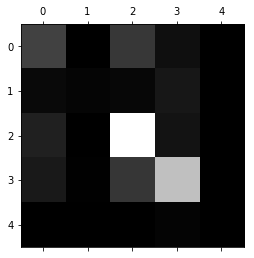

In [51]:
from sklearn.metrics import confusion_matrix
y_train_pred=cross_val_predict(forest_clf, x_train, y_train.ravel())
conf_mx=confusion_matrix(y_train, y_train_pred)

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

#### AdaBoost Classifier
Trains on adjusted sample distributions. AdaBoost will take multiple weak learners, in this case decision trees, and combine them into a strong learner. Every new tree that AdaBoost uses adapts to the weak learners by attempting to improve upon misclassifications from earlier trees. 

In [52]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
ada_clf=AdaBoostClassifier(DecisionTreeClassifier(max_features=500, max_depth=10), n_estimators=100, random_state=42)
ada_clf.fit(x_train,y_train.ravel())
ada_clf_pred=ada_clf.predict(x_train)

In [53]:
from sklearn import metrics
score=metrics.accuracy_score(y_train, ada_clf_pred)
print("Ada Train Accuracy= ", score)

Ada Train Accuracy=  0.864892671749


In [54]:
ada_clf_preds=ada_clf.predict(x_test)
score=metrics.accuracy_score(y_test, ada_clf_preds)
print("Ada Test Accuracy= ",score)
print("Ada Test Log-Loss=" ,log_loss(y_test, ada_clf.predict_proba(x_test)))

Ada Test Accuracy=  0.60531238309
Ada Test Log-Loss= 0.925278339136


#### Gradient Boosting Classifier
Our last ensemble method also takes many weak (tree) learners and fits each new learner to the residual errors of the last.

In [56]:
from sklearn.ensemble import GradientBoostingClassifier
gbm_clf=GradientBoostingClassifier(max_features=500, max_depth=10, random_state=42)
gbm_clf.fit(x_train,y_train.ravel())
gbm_clf_pred=gbm_clf.predict(x_train)

In [57]:
print("GBM Train Accuracy= ", metrics.accuracy_score(y_train, gbm_clf_pred))

GBM Train Accuracy=  0.854229995791


In [58]:
gbm_clf_preds=gbm_clf.predict(x_test)
score=metrics.accuracy_score(y_test, gbm_clf_preds)
print("GBM Test Accuracy= ",score)
print("GBM Test Log-Loss= ",log_loss(y_test, gbm_clf.predict_proba(x_test)))

GBM Test Accuracy=  0.675645342312
GBM Test Log-Loss=  0.791823084333


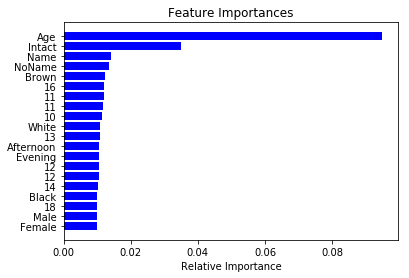

In [59]:
features = x_train.columns.copy() #CHECK THIS
importances = gbm_clf.feature_importances_
indices = np.argsort(importances)
indices=indices[-20:]

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices]) ## removed [indices]
plt.xlabel('Relative Importance')
plt.show()
